In [1]:
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import Rbf

## Task 1: State Space Embedding

Shape (14002, 10)


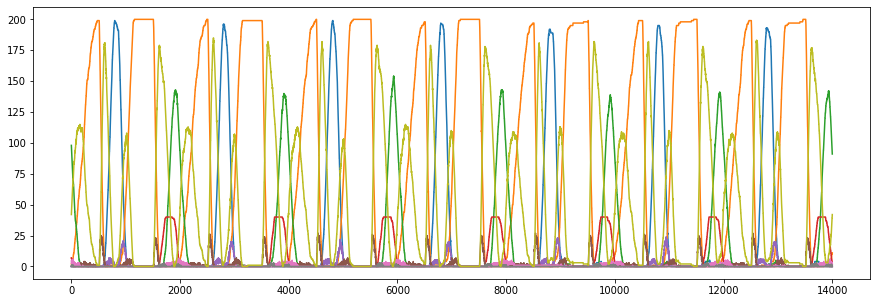

In [2]:
# Load the data from the text file (assuming it's a space-separated file)
data = np.loadtxt('MI_timesteps.txt', delimiter=' ', skiprows=1000)

# Set the figure size
plt.figure(figsize=(15, 5))

# Iterate over each measurment in the data array
for i in range(1, data.shape[1]):
    plt.plot(data[:, i])

print("Shape", data.shape)

In [3]:
measurement_areas = data[:, 1:4]

M = data.shape[0] - 351
windows_matrix = np.zeros((M, 1053))

for i in range(M):
    windows_matrix[i] = measurement_areas[i:i + 351, :].flatten()

In [4]:
# Extract the columns for the delay embedding
delay_embedding = data[:, 1:4]

print(delay_embedding.shape)

# Create the delay embedding windows
window_size = 351
M = data.shape[0] - window_size
windows = [delay_embedding[i:i+window_size] for i in range(M)]

# Convert each window into a vector of length 1053
vectors = [window.flatten() for window in windows]

# Apply PCA
pca = PCA(n_components=3)
pca.fit(vectors)
embedding = pca.transform(vectors)
print("pca", embedding.shape)

(14002, 3)
pca (13651, 3)


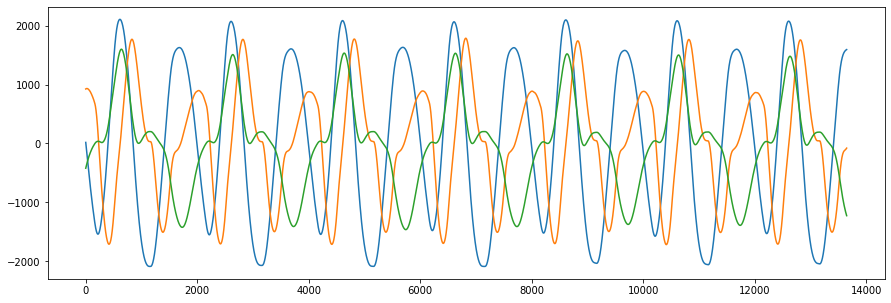

In [5]:
plt.figure(figsize=(15, 5))

for i in range(embedding.shape[1]):
    plt.plot(embedding[:,i])

## Task 2: Coloring Points in the Embedding Space

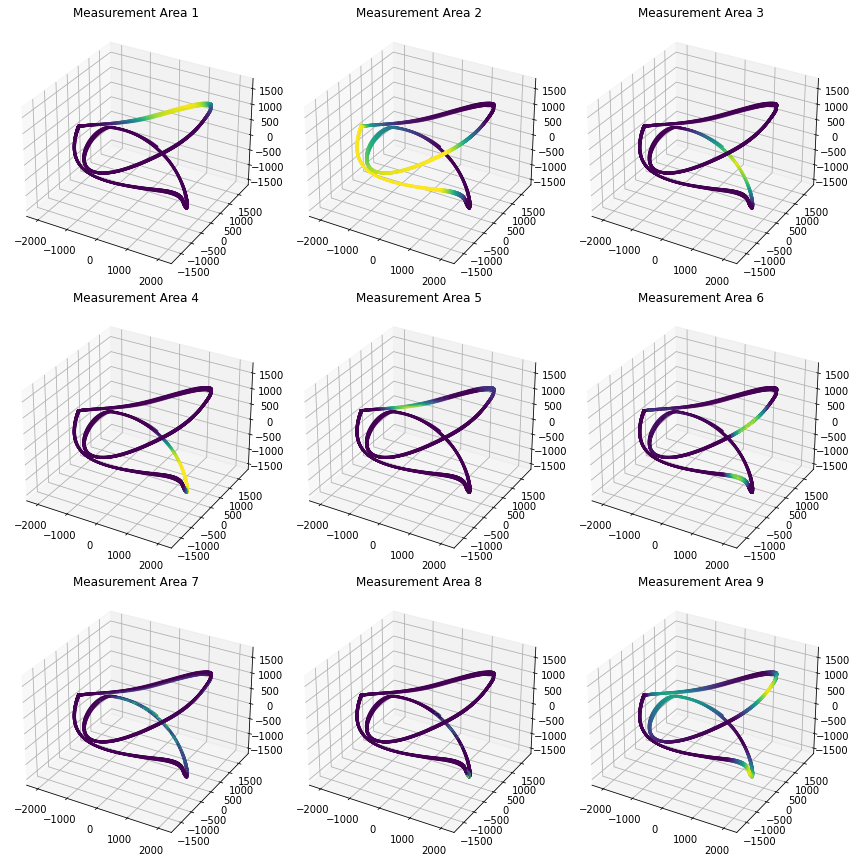

In [6]:
# Create subplots for the figures
fig, axes = plt.subplots(3, 3, figsize=(12, 12), subplot_kw={'projection': '3d'})

# Create nine scatter plots
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], s=1, c=data[:M, i * 3 + j + 1])
        ax.set_title(f"Measurement Area {i * 3 + j + 1}")

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

## Task 3 : Learning Dynamics on the Periodic Curve:

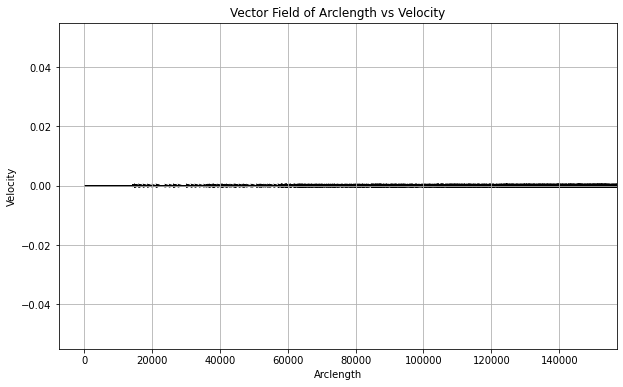

In [7]:
# Compute the arclength of the curve in the PCA space
arclengths = np.cumsum(np.linalg.norm(np.diff(embedding, axis=0), axis=1))

# Compute the change of arclength over time
time_steps = data[:M, 0]  # Assuming the time steps are in the first column
delta_arclengths = np.diff(arclengths)
delta_time_steps = np.diff(time_steps)

# Adjust the shape of delta_arclengths to match delta_time_steps
delta_arclengths = delta_arclengths[:len(delta_time_steps)]

# Compute the change of arclength over time by dividing the arrays
velocity = delta_arclengths / np.mean(delta_time_steps)

# Create a vector field on the arclength
vector_field = np.column_stack((arclengths[:-1], velocity))

# Plot the vector field
plt.figure(figsize=(10, 6))
plt.quiver(vector_field[:, 0], np.zeros_like(vector_field[:, 0]), vector_field[:, 1], np.zeros_like(vector_field[:, 1]), scale=10)
plt.xlabel('Arclength')
plt.ylabel('Velocity')
plt.title('Vector Field of Arclength vs Velocity')
#plt.xlim(0, 2*np.pi)  # Set x-axis limits
plt.grid()
plt.show()

## Task 4 : Predicting Utilization of the MI Building:

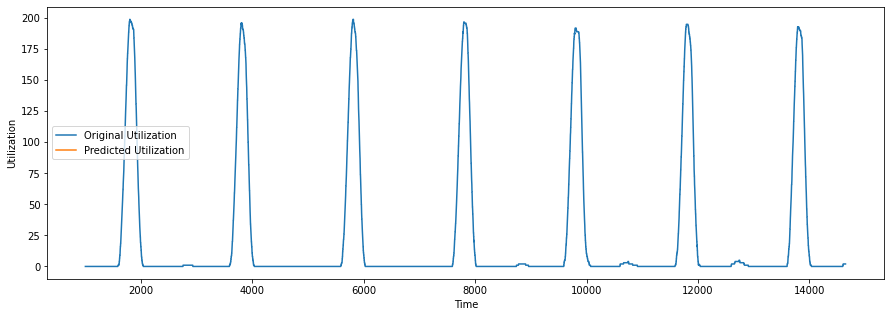

In [11]:
# Integrate the vector field to obtain arclength values over time
arclength_values = np.cumsum(delta_arclengths) + arclengths[0]

# Ensure arclength_values and data[:M, 1] have the same length
arclength_values = arclength_values[:M]
utilization_values = data[:M, 1][:len(arclength_values)]
time_steps = time_steps[:len(utilization_values)]

# Create a radial basis function approximation
rbf = Rbf(arclength_values, utilization_values, smooth=0.5)

# Predict the utilization for the next 14 days
future_arclengths = np.linspace(arclength_values[-1], arclength_values[-1] + 14, num=14)
predicted_utilization = rbf(future_arclengths)

# Plot the results over time
plt.figure(figsize=(15, 5))
plt.plot(time_steps, utilization_values, label='Original Utilization')
plt.plot(time_steps[-1] + np.arange(1, 15), predicted_utilization, label='Predicted Utilization')
plt.xlabel('Time')
plt.ylabel('Utilization')
plt.legend()
plt.show()